In [ ]:
# This tests some tutorial code for Celerite2

# Created 2021 Aug. 6 by E.S.

In [ ]:
# Ref https://celerite2.readthedocs.io/en/latest/tutorials/first/

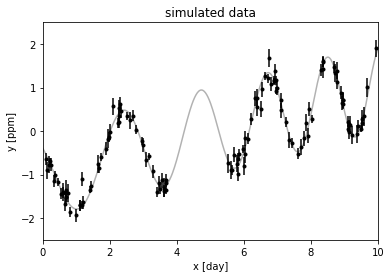

In [2]:
# generate fake data

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [3]:
# fit dataset using SHOT terms

import celerite2
from celerite2 import terms

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(t, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -16.751640798326292


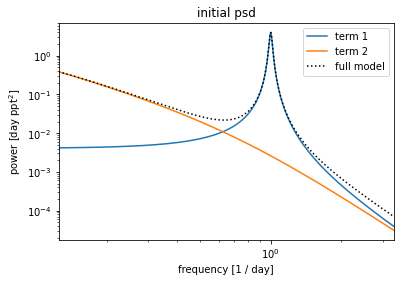

In [4]:
# look at underlying PSD

freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label="term {0}".format(n + 1))
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)

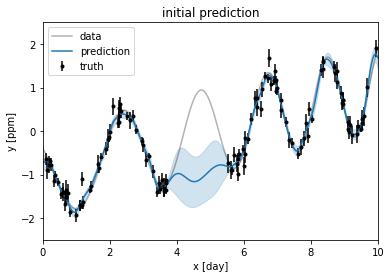

In [5]:
# make prediction

def plot_prediction(gp):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="prediction")
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)

In [7]:
# make better solution by maximizing likelihood function with a jitter term

from scipy.optimize import minimize


def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(t, diag=yerr ** 2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(y)


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

      fun: -15.942826327897862
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.67910172e-05,  8.58335625e-04,  1.98241422e-03, -9.66338127e-05,
        3.14059888e-04, -2.48689959e-04,  1.70530258e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 392
      nit: 42
     njev: 49
   status: 0
  success: True
        x: array([ 4.53458294e-03, -3.41454516e-01,  7.00017137e-01,  1.94378016e+00,
        6.05915878e-01,  3.75546617e+00, -7.87242729e+00])

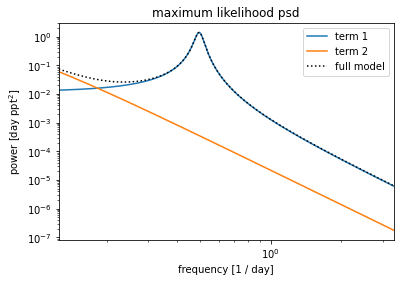

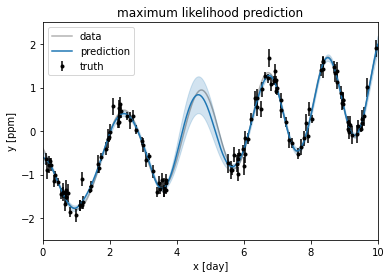

In [8]:
# make plots

plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

plt.figure()
plt.title("maximum likelihood prediction")
plot_prediction(opt_gp)

In [11]:
# posterior inference using MCMC

import emcee

prior_sigma = 2.0


def log_prob(params, gp):
    gp = set_params(params, gp)
    return (
        gp.log_likelihood(y) - 0.5 * np.sum((params / prior_sigma) ** 2),
        gp.kernel.get_psd(omega),
    )


np.random.seed(5693854)
coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob, args=(gp,)
)
state = sampler.run_mcmc(coords, 2000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 5000, progress=True)

You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee


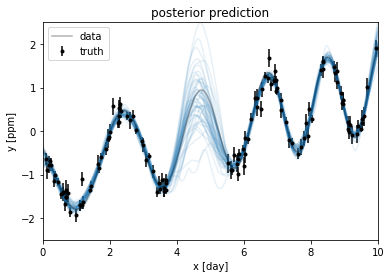

In [12]:
# make plot

chain = sampler.get_chain(discard=100, flat=True)

for sample in chain[np.random.randint(len(chain), size=50)]:
    gp = set_params(sample, gp)
    conditional = gp.condition(y, true_t)
    plt.plot(true_t, conditional.sample(), color="C0", alpha=0.1)

plt.title("posterior prediction")
plot_prediction(None)

In [ ]:
# ... etc.